# How To: Configure and perform constrained optimization in Rockpool

In [1]:
# - Make sure additional required packages are installed
import sys
!{sys.executable} -m pip install --quiet rich torch jax optax

from rich import print

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

import numpy as np
import torch, jax, optax


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


/Users/Shared/anaconda3/envs/py38/lib/python3.8/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


## `torch` interface for constrained optimization

In [2]:
# - Import the LIF module we will use
from rockpool.nn.modules import LIFTorch

# - Create a single LIF module
net = LIFTorch(1)
print('Module:', net)
print('Parameters:', net.parameters())

Module: LIFTorch  with shape (1, 1)

Parameters:
{
    'tau_mem': Parameter containing:
tensor([0.0200], requires_grad=True),
    'tau_syn': Parameter containing:
tensor([[0.0200]], requires_grad=True),
    'bias': Parameter containing:
tensor([0.], requires_grad=True),
    'threshold': Parameter containing:
tensor([1.], requires_grad=True)
}

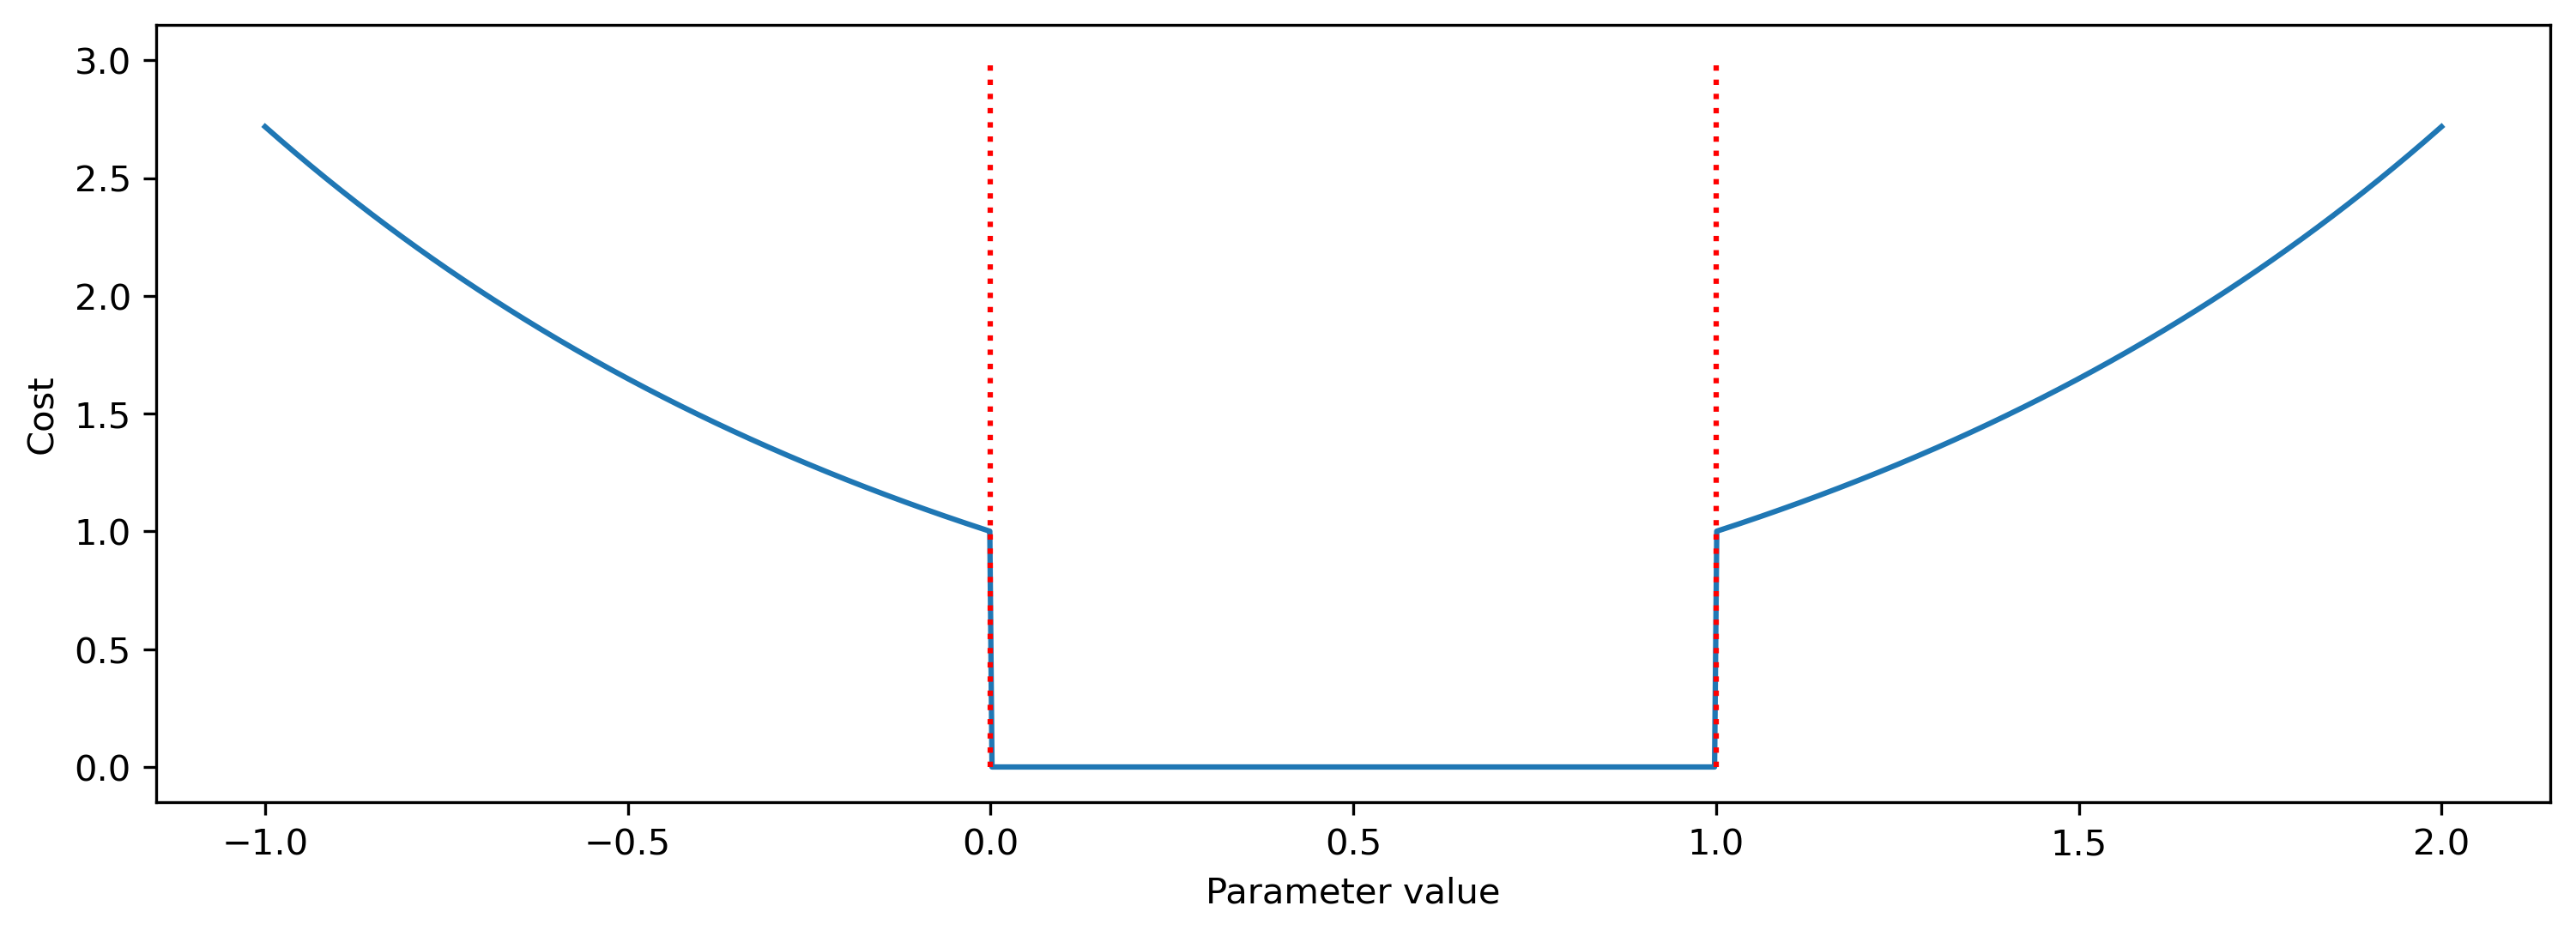

In [3]:
# - Import the `make_bounds` and `bounds_cost` helper functions
from rockpool.training.torch_loss import make_bounds, bounds_cost

xs = np.linspace(-1, 2, 1001)
cost = [bounds_cost({'x': torch.tensor(x)}, {'x': 0.}, {'x': 1.}) for x in xs]

plt.figure()
plt.plot(xs, cost)
plt.plot([0, 0], [0, 3], 'r:')
plt.plot([1, 1], [0, 3], 'r:')
plt.xlabel('Parameter value')
plt.ylabel('Cost');

In [4]:
# - Call `make_bounds` on the parameters of the module
lb, ub = make_bounds(net.parameters())
print(lb, ub)

{'tau_mem': -inf, 'tau_syn': -inf, 'bias': -inf, 'threshold': -inf}
{'tau_mem': inf, 'tau_syn': inf, 'bias': inf, 'threshold': inf}

In [5]:
lb['tau_syn'] = 0.
ub['tau_syn'] = 200e-3
print(lb, ub)

{'tau_mem': -inf, 'tau_syn': 0.0, 'bias': -inf, 'threshold': -inf}
{'tau_mem': inf, 'tau_syn': 0.2, 'bias': inf, 'threshold': inf}

In [6]:
# - Evaluate the boundary constraint cost
print(bounds_cost(net.parameters(), lb, ub))

tensor(0., grad_fn=<SumBackward0>)

In [7]:
from rockpool.nn.modules import LinearTorch
from rockpool.nn.combinators import Sequential, Residual

net = Sequential(
    LinearTorch((2, 3)),
    LIFTorch(3, leak_mode="decays"),

    Residual(
        LinearTorch((3, 3)),
        LIFTorch(3, leak_mode="decays"),
    ),

    LinearTorch((3, 5)),
    LIFTorch(5, leak_mode="taus"),
)
print('Network:', net)
print('Parameters:', net.parameters())

Network: TorchSequential  with shape (2, 5) {
    LinearTorch '0_LinearTorch' with shape (2, 3)
    LIFTorch '1_LIFTorch' with shape (3, 3)
    TorchResidual '2_TorchResidual' with shape (3, 3) {
        LinearTorch '0_LinearTorch' with shape (3, 3)
        LIFTorch '1_LIFTorch' with shape (3, 3)
    }
    LinearTorch '3_LinearTorch' with shape (3, 5)
    LIFTorch '4_LIFTorch' with shape (5, 5)
}

Parameters:
{
    '0_LinearTorch': {
        'weight': Parameter containing:
tensor([[-1.7288,  0.3565,  0.7264],
        [-0.9882, -1.2147,  1.2812]], requires_grad=True)
    },
    '1_LIFTorch': {
        'alpha': Parameter containing:
tensor([0.5000, 0.5000, 0.5000], requires_grad=True),
        'beta': Parameter containing:
tensor([[0.5000],
        [0.5000],
        [0.5000]], requires_grad=True),
        'bias': Parameter containing:
tensor([0., 0., 0.], requires_grad=True),
        'threshold': Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
    },
    '2_TorchResidual': {
        '0_LinearTorch': {
            'weight': Parameter containing:
tensor([[ 0.7141, -1.3781, -0.7695],
        [-0.8757, -0.6188, -0.4058],
        [-0.8914,  0.4774,  0.1480]], requires_grad=True)
        },
        '1_LIFTorch': {
            'alpha': Parameter containing:
tensor([0.5000, 0.5000, 0.5000], requires_grad=True),
            'beta': Parameter containing:
tensor([[0.5000],
        [0.5000],
        [0.5000]], requires_grad=True),
            'bias': Parameter containing:
tensor([0., 0., 0.], requires_grad=True),
            'threshold': Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
        }
    },
    '3_LinearTorch': {
        'weight': Parameter containing:
tensor([[ 0.4936,  1.3029, -1.0018,  1.1015, -1.4031],
        [ 0.1428,  1.2207,  1.1742,  0.8693, -0.3616],
        [ 0.1114, -1.3645, -1.3504, -0.6766, -0.4882]], requires_grad=True)
    },
    '4_LIFTorch': {
        'tau_mem': Parameter containing:
tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200], requires_grad=True),
        'tau_syn': Parameter containing:
tensor([[0.0200],
        [0.0200],
        [0.0200],
        [0.0200],
        [0.0200]], requires_grad=True),
        'bias': Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True),
        'threshold': Parameter containing:
tensor([1., 1., 1., 1., 1.], requires_grad=True)
    }
}

In [8]:
# - Import the tree utilities library
import rockpool.utilities.tree_utils as tu

# - Make template lower and upper bounds
lb, ub = make_bounds(net.parameters())

# - Set lower bounds on "decays" and "taus" family parameters
lb = tu.set_matching(lb, net.parameters('decays'), 0.5)
lb = tu.set_matching(lb, net.parameters('taus'), 0.)

# - Set upper bounds on "decays" family parameters
ub = tu.set_matching(ub, net.parameters('decays'), 1.)

# - Set an upper bound on a specific parameter name
ub = tu.set_matching(ub, net.attributes_named('tau_syn'), 500e-3)

print(lb, ub)

{
    '0_LinearTorch': {'weight': -inf},
    '1_LIFTorch': {'alpha': 0.5, 'beta': 0.5, 'bias': -inf, 'threshold': -inf},
    '2_TorchResidual': {
        '0_LinearTorch': {'weight': -inf},
        '1_LIFTorch': {'alpha': 0.5, 'beta': 0.5, 'bias': -inf, 'threshold': -inf}
    },
    '3_LinearTorch': {'weight': -inf},
    '4_LIFTorch': {'tau_mem': 0.0, 'tau_syn': 0.0, 'bias': -inf, 'threshold': -inf}
}
{
    '0_LinearTorch': {'weight': inf},
    '1_LIFTorch': {'alpha': 1.0, 'beta': 1.0, 'bias': inf, 'threshold': inf},
    '2_TorchResidual': {
        '0_LinearTorch': {'weight': inf},
        '1_LIFTorch': {'alpha': 1.0, 'beta': 1.0, 'bias': inf, 'threshold': inf}
    },
    '3_LinearTorch': {'weight': inf},
    '4_LIFTorch': {'tau_mem': inf, 'tau_syn': 0.5, 'bias': inf, 'threshold': inf}
}

In [9]:
# - Evaluate the boundary constraint cost for the full set of network parameters
print(bounds_cost(net.parameters(), lb, ub))

tensor(0., grad_fn=<SumBackward0>)

In [10]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# - Initialise the optimiser
optimizer = Adam(net.parameters().astorch(), lr=1e-3)
func_loss = CrossEntropyLoss()

# - Dummy dataset
dataset = [(torch.tensor(np.random.rand(1, 1, 2), dtype=torch.float), torch.tensor(np.random.rand(1, 1, 5), dtype=torch.float))]

# - Optimiser loop over dataset
for input, target in dataset:
    optimizer.zero_grad()
    output, _, _ = net(input)

    # - Evaluate the functional and constraints losses
    loss = func_loss(output, target) + bounds_cost(net.parameters(), lb, ub)

    # - Perform the backward step
    loss.backward()
    optimizer.step()

## `jax` interface for constrained optimization

In [11]:
# - Import the Rockpool NN modules
from rockpool.nn.modules import LIFJax, LinearJax
from rockpool.nn.combinators import Sequential

# - Import tools from ``jax_loss`` instead of ``torch_loss``
from rockpool.training.jax_loss import make_bounds, bounds_cost

# - Import the tree utility package
from rockpool.utilities import tree_utils as tu

In [12]:
# - Set up a simple network
net = Sequential(
    LinearJax((2, 3)),
    LIFJax(3),
    LinearJax((3, 5)),
    LIFJax(5),
)
print('Network:', net)
print('Parameters:', net.parameters())

Network: JaxSequential  with shape (2, 5) {
    LinearJax '0_LinearJax' with shape (2, 3)
    LIFJax '1_LIFJax' with shape (3, 3)
    LinearJax '2_LinearJax' with shape (3, 5)
    LIFJax '3_LIFJax' with shape (5, 5)
}

Parameters:
{
    '0_LinearJax': {
        'weight': array([[ 1.45853284, -1.09957019, -0.31666267],
       [ 0.63834515,  1.47955107,  1.03358989]])
    },
    '1_LIFJax': {
        'tau_mem': DeviceArray([0.02, 0.02, 0.02], dtype=float32),
        'tau_syn': DeviceArray([[0.02],
             [0.02],
             [0.02]], dtype=float32),
        'bias': DeviceArray([0., 0., 0.], dtype=float32),
        'threshold': DeviceArray([1., 1., 1.], dtype=float32)
    },
    '2_LinearJax': {
        'weight': array([[ 0.3648217 ,  0.34105733,  1.23947428, -0.42756732,  0.6361447 ],
       [-0.19837451,  0.61290813,  1.25214626,  1.206278  ,  0.70346237],
       [ 0.73964399, -1.02753273, -0.28541291, -1.10618743,  0.78135608]])
    },
    '3_LIFJax': {
        'tau_mem': DeviceArray([0.02, 0.02, 0.02, 0.02, 0.02], dtype=float32),
        'tau_syn': DeviceArray([[0.02],
             [0.02],
             [0.02],
             [0.02],
             [0.02]], dtype=float32),
        'bias': DeviceArray([0., 0., 0., 0., 0.], dtype=float32),
        'threshold': DeviceArray([1., 1., 1., 1., 1.], dtype=float32)
    }
}

In [13]:
# - Build a template configuration
lb, ub = make_bounds(net.parameters())
print(lb, ub)

{
    '0_LinearJax': {'weight': -inf},
    '1_LIFJax': {'bias': -inf, 'tau_mem': -inf, 'tau_syn': -inf, 'threshold': -inf},
    '2_LinearJax': {'weight': -inf},
    '3_LIFJax': {'bias': -inf, 'tau_mem': -inf, 'tau_syn': -inf, 'threshold': -inf}
}
{
    '0_LinearJax': {'weight': inf},
    '1_LIFJax': {'bias': inf, 'tau_mem': inf, 'tau_syn': inf, 'threshold': inf},
    '2_LinearJax': {'weight': inf},
    '3_LIFJax': {'bias': inf, 'tau_mem': inf, 'tau_syn': inf, 'threshold': inf}
}

In [14]:
# - Set lower bounds for time constants
lb = tu.set_matching(lb, net.parameters('taus'), 0.)
print(lb)

{
    '0_LinearJax': {'weight': -inf},
    '1_LIFJax': {'bias': -inf, 'tau_mem': 0.0, 'tau_syn': 0.0, 'threshold': -inf},
    '2_LinearJax': {'weight': -inf},
    '3_LIFJax': {'bias': -inf, 'tau_mem': 0.0, 'tau_syn': 0.0, 'threshold': -inf}
}

In [15]:
# - Evaluate the boundary constraint cost
print(bounds_cost(net.parameters(), lb, ub))

0.0

In [16]:
# - Initialise the Adam optimiser with the initial network parameters
optimizer = optax.adam(1e-4)
params = net.parameters()
opt_state = optimizer.init(params)

# - Use an MSE loss
func_loss = lambda o, t: jax.numpy.mean((o - t) ** 2)

# - Network evaluation and loss function
def eval_loss(params, net, input, target):
    output, _, _ = net(input)
    loss = func_loss(output, target) + bounds_cost(params, lb, ub)

    return loss

# - Dummy dataset
dataset = [(np.random.rand(1, 1, 2), np.random.rand(1, 1, 5))]

# - Loop over dataset, evaluating loss and applying updates
for input, target in dataset:
    loss_value, grads = jax.value_and_grad(eval_loss)(params, net, input, target)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

## Next steps